In [1]:
# SET INPUT DIR WHERE LABELS WILL BE SAVED

input_dir = '../../demo_images'

%matplotlib inline
import os
import cv2
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
from ipycanvas import Canvas
import numpy as np
from PIL import Image as PILImage
import io

# Register widgets properly
from ipywidgets import embed
# registration method (ipywidgets 8+)
@widgets.register
class MyCanvas(Canvas):
    pass

class CarCounter:
    def __init__(self, image_dir, output_csv):
        self.image_dir = image_dir
        self.output_csv = output_csv
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.current_index = 0
        self.car_boxes = {}  # Stores {image_name: list of YOLO format boxes}
        self.current_boxes = []  # Current image's boxes in YOLO format
        self.temp_points = []  # Stores temporary points for current box
        self.mask = None
        self.has_mask = False
        
        # Load existing data if CSV exists
        if os.path.exists(output_csv):
            # df = pd.read_csv(output_csv)
            df = pd.read_csv(f'{input_dir}/output_labels_latest_tiny.csv')
            self.car_boxes = {row['image_name']: eval(row['yolo_boxes']) for _, row in df.iterrows()}
        
        # Create widgets
        self.count_display = widgets.Label(value="Marked spots: 0 (Click on the upper-left corner and then on the lower-right corner in the center of each spot))")
        self.image_name_display = widgets.Label()
        self.next_button = widgets.Button(description="Próxima Imagem", layout=widgets.Layout(width='150px'))
        self.prev_button = widgets.Button(description="Imagem Anterior", layout=widgets.Layout(width='150px'))
        self.save_button = widgets.Button(description="Salvar Progresso", layout=widgets.Layout(width='150px'))
        self.undo_button = widgets.Button(description="Desfazer Última Caixa", layout=widgets.Layout(width='150px'))
        self.warning_label = widgets.Label(value="", style={'color': 'red'})
        self.instructions = widgets.HTML(
            value="""<b>Instruções:</b><br>
            Click on the upper-left corner and then on the lower-right center of each spot.<br>
            <b></b>"""
        )

        # Canvas (fixed size for all images)
        self.canvas_width = 800
        self.canvas_height = 600
        self.canvas = Canvas(width=self.canvas_width, height=self.canvas_height)
        self.canvas.on_mouse_down(self.handle_canvas_click)
        
        # Set up event handlers
        self.next_button.on_click(self.next_image)
        self.prev_button.on_click(self.prev_image)
        self.save_button.on_click(self.save_counts)
        self.undo_button.on_click(self.undo_last_box)
        
        # Create a box for buttons
        button_box = widgets.HBox(
            [self.prev_button, self.next_button, self.undo_button, self.save_button],
            layout=widgets.Layout(justify_content='space-between', width=f'{self.canvas_width}px')
        )
        
        # Create the main layout
        self.main_layout = widgets.VBox([
            self.instructions,
            button_box,
            self.image_name_display,
            self.canvas,
            self.count_display,
            self.warning_label
        ], layout=widgets.Layout(
            width=f'{self.canvas_width + 20}px',
            border='solid 1px lightgray',
            padding='10px'
        ))
        
        # Display the UI
        display(self.main_layout)
        
        # Load first image
        self.load_image()

    def load_mask(self, cam_number):
        """Load mask for specified camera"""
        mask_path = os.path.join(f'cam_reitoria_{cam_number}_mask.jpg')
        print(f"Loading mask from: {mask_path}")
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            # mask = cv2.resize(mask, (self.canvas_width, self.canvas_height))
            return mask
        else:
            return None



    
    def load_image(self):
        if self.current_index >= len(self.image_files):
            print("Todas as imagens foram processadas!")
            return
            
        self.current_file = self.image_files[self.current_index]
        self.image_name_display.value = f"Imagem {self.current_index + 1}/{len(self.image_files)}: {self.current_file}"
        
        # Check if camera 2 or 3 and load mask
        self.has_mask = False
        # print(f"Loading image: {self.current_file}")
        if 'cam_reitoria_2' in self.current_file:
            self.mask = self.load_mask(2)
            # print(f"Loaded mask for camera 2: {self.mask.shape if self.mask is not None else 'None'}")
            self.has_mask = True
        elif 'cam_reitoria_3' in self.current_file:
            self.mask = self.load_mask(3)
            self.has_mask = True
        else:
            self.mask = None
        
        # Load image
        image_path = os.path.join(self.image_dir, self.current_file)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error loading image: {image_path}")
            return
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        self.original_shape = image.shape[:2]
        
        # Resize to canvas size
        self.current_image = cv2.resize(image, (self.canvas_width, self.canvas_height))
        
        # Create display image with mask overlay
        self.display_image = self.current_image.copy()
        if self.has_mask and self.mask is not None:
            # Resize mask to match canvas dimensions
            mask_resized = cv2.resize(self.mask, (self.canvas_width, self.canvas_height))
            
            # Create semi-transparent red overlay where mask is white
            mask_overlay = np.zeros_like(self.current_image)
            mask_overlay[mask_resized > 0] = [255, 0, 0]  # Red where mask is white
            
            # Apply overlay with transparency
            self.display_image = cv2.addWeighted(self.current_image, 0.7, mask_overlay, 0.3, 0)
        
        self.temp_points = []
        self.current_boxes = self.car_boxes.get(self.current_file, [])
        self.count_display.value = f"Carros marcados: {len(self.current_boxes)}"
        self.warning_label.value = ""
        
        self.update_display()


    def update_display(self):
        """Update canvas display with image and boxes"""
        # Put the base image with mask overlay
        self.canvas.put_image_data(self.display_image, 0, 0)
        
        # Draw existing boxes
        for box in self.current_boxes:
            self.draw_yolo_box(box)
            
        # Draw temporary points
        for i, (x, y) in enumerate(self.temp_points):
            self.canvas.fill_style = 'red' if i % 2 == 0 else 'blue'
            self.canvas.fill_circle(x, y, 5)
            
            # Draw rectangle if we have two points
            if len(self.temp_points) >= 2 and i % 2 == 1:
                x1, y1 = self.temp_points[i-1]
                self.canvas.stroke_style = 'green'
                self.canvas.line_width = 2
                self.canvas.stroke_rect(x1, y1, x-x1, y-y1)

    def draw_yolo_box(self, yolo_box):
        """Draw YOLO format box on canvas"""
        _, x_center, y_center, width, height = yolo_box
        
        # Convert from YOLO to pixel coordinates
        img_width, img_height = self.canvas_width, self.canvas_height
        box_width = width * img_width
        box_height = height * img_height
        x = (x_center * img_width) - (box_width / 2)
        y = (y_center * img_height) - (box_height / 2)
        
        # Draw the box
        self.canvas.stroke_style = 'green'
        self.canvas.line_width = 2
        self.canvas.stroke_rect(x, y, box_width, box_height)

    def is_point_in_mask(self, x, y):
        """Check if point is inside mask"""
        if not self.has_mask or self.mask is None:
            return False
        
        x_int = int(x)
        y_int = int(y)
        
        if 0 <= x_int < self.mask.shape[1] and 0 <= y_int < self.mask.shape[0]:
            return self.mask[y_int, x_int] > 0
        return False

    def handle_canvas_click(self, x, y):
        """Handle canvas click event"""
        self.handle_click(x, y)

    def handle_click(self, x, y):
        """Register click at coordinates (x, y)"""
        if self.is_point_in_mask(x, y):
            self.warning_label.value = "AVISO: Ponto selecionado dentro da máscara! Não marque carros nesta área."
            return
        
        self.temp_points.append((x, y))
        
        if len(self.temp_points) >= 2 and len(self.temp_points) % 2 == 0:
            x1, y1 = self.temp_points[-2]
            x2, y2 = self.temp_points[-1]
            
            if (self.is_point_in_mask(x1, y1) or self.is_point_in_mask(x2, y2) or
                self.is_point_in_mask((x1+x2)/2, (y1+y2)/2)):
                self.warning_label.value = "AVISO: Carro marcado parcial ou totalmente dentro da máscara! Remova esta marcação."
                self.temp_points = self.temp_points[:-2]
                return
            
            img_width, img_height = self.canvas_width, self.canvas_height
            x_min, x_max = sorted([x1, x2])
            y_min, y_max = sorted([y1, y2])
            
            box_width = (x_max - x_min) / img_width
            box_height = (y_max - y_min) / img_height
            x_center = ((x_min + x_max) / 2) / img_width
            y_center = ((y_min + y_max) / 2) / img_height
            
            yolo_box = (0, x_center, y_center, box_width, box_height)
            self.current_boxes.append(yolo_box)
            self.car_boxes[self.current_file] = self.current_boxes
            self.temp_points = []
            self.count_display.value = f"Carros marcados: {len(self.current_boxes)}"
            self.warning_label.value = ""
        
        self.update_display()

    def undo_last_box(self, _):
        """Remove last complete box"""
        if self.current_boxes:
            self.current_boxes.pop()
            self.car_boxes[self.current_file] = self.current_boxes
            self.temp_points = []
            self.count_display.value = f"Carros marcados: {len(self.current_boxes)}"
            self.warning_label.value = ""
            self.update_display()
        elif self.temp_points:
            self.temp_points = []
            self.update_display()

    def next_image(self, _):
        if self.current_index < len(self.image_files) - 1:
            self.current_index += 1
            self.temp_points = []
            self.load_image()

    def prev_image(self, _):
        if self.current_index > 0:
            self.current_index -= 1
            self.temp_points = []
            self.load_image()

    def save_counts(self, _):
        data = []
        for image_name, boxes in self.car_boxes.items():
            data.append({
                'image_name': image_name,
                'real_cars': len(boxes),
                'yolo_boxes': str(boxes)
            })
        
        df = pd.DataFrame(data)
        df.to_csv(self.output_csv, index=False)
        # df.to_csv(f'{input_dir}/output_labels_latest_tiny_refac.csv', index=False)
        print(f"Progresso salvo em {self.output_csv}")

from IPython.display import clear_output
clear_output()
# Usage:
counter = CarCounter(input_dir, f'spot_wise_labels.csv')
# counter = CarCounter(input_dir, f'{input_dir}/output_labels_latest_tiny_refac.csv')
    
    


Progresso salvo em ../../demo_images/spot_wise_labels.csv
Progresso salvo em ../../demo_images/spot_wise_labels.csv


In [3]:
#test environment
# !pip install --upgrade ipycanvas ipywidgets
# from ipycanvas import Canvas
# canvas = Canvas(width=200, height=200)
# canvas.fill_rect(25, 25, 100, 100)
# display(canvas)

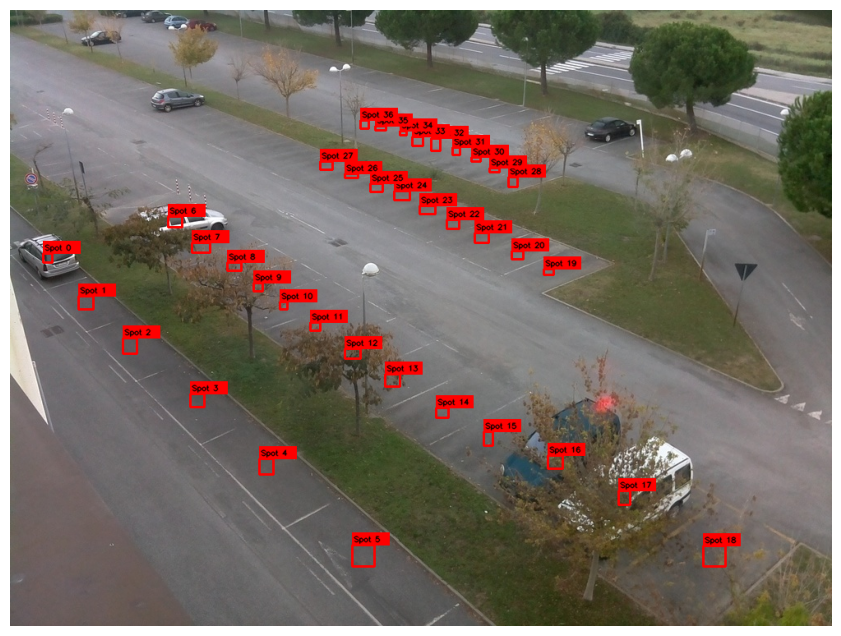

In [5]:
import ast
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_boxes_on_image(image_path, yolo_boxes, display=True, save_path=None):
    """
    Plot YOLO format bounding boxes on an image.
    
    Args:
        image_path: Path to the image file
        yolo_boxes: List of YOLO format boxes [(class, x_center, y_center, width, height)]
        display: Whether to display the image
        save_path: If provided, save the image with boxes to this path
    """
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    
    # Draw each box
    for idx,box in enumerate(yolo_boxes):
        class_id, x_center, y_center, box_width, box_height = box
        
        # Convert YOLO to pixel coordinates
        x_center *= width
        y_center *= height
        box_width *= width
        box_height *= height
        
        x_min = int(x_center - box_width/2)
        y_min = int(y_center - box_height/2)
        x_max = int(x_center + box_width/2)
        y_max = int(y_center + box_height/2)
        
        # Draw rectangle
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        # cv2.putText(image, f'Spot {idx}', (x_min, y_min-5), 
        #            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        # cv2.rectangle(image, (x_min, y_min-20), (x_min+60, y_min), (255, 0, 0), -1)  # Filled rectangle for text background
        # cv2.putText(image, f'Spot {idx}', (x_min, y_min-5), 
        #            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        # Smaller filled rectangle for text background
        cv2.rectangle(image, (x_min, y_min - 15), (x_min + 45, y_min), (255, 0, 0), -1)

        # Smaller text (font scale 0.4 instead of 0.5)
        cv2.putText(image, f'Spot {idx}', (x_min + 2, y_min - 4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1, cv2.LINE_AA)

    
    # Display or save
    if display:
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    
    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
    return image

def visualize_boxes_from_csv(csv_path, image_dir, num_images=5, save_dir=None):
    """
    Visualize bounding boxes from CSV file.
    
    Args:
        csv_path: Path to CSV file with yolo_boxes column
        image_dir: Directory containing the images
        num_images: Number of random images to visualize
        save_dir: Directory to save images with boxes (optional)
    """
    # Read CSV
    df = pd.read_csv(csv_path)
    
    # Convert string representation of list to actual list
    df['yolo_boxes'] = df['yolo_boxes'].apply(ast.literal_eval)
    
    # Select random images if we don't want to visualize all
    if num_images < len(df):
        df = df.sample(num_images)
    
    # Create save directory if needed
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Process each image
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_name'])
        yolo_boxes = row['yolo_boxes']
        
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue
        
        save_path = os.path.join(save_dir, row['image_name']) if save_dir else None
        plot_boxes_on_image(image_path, yolo_boxes, save_path=save_path)

# Usage example:
csv_path = 'spot_wise_labels.csv'
image_dir = input_dir
# save_dir = './test_set_1mai25/visualized_boxes/'  # Optional - set to None if you don't want to save

visualize_boxes_from_csv(csv_path, image_dir, num_images=5, save_dir='./')